# Comparing clustering algorithms with Motion Capture data

This is jsut the preliminary version of the report.

## 1. Loading the MoCap dataset
The dataset can be dowloaded from https://archive.ics.uci.edu/ml/datasets/MoCap+Hand+Postures


In [15]:
# importing the relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [16]:
dat = pd.read_csv('mocap.csv')
dat.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


In [17]:
# the first row can be removed
dat = dat.iloc[1:]
dat.reset_index
dat.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,?,?,?,?,?,?,?,?,?,?


In [18]:
y = dat['Class']

In [19]:
np.unique(y)

array([1, 2, 3, 4, 5])

In [25]:
X=np.array(dat.iloc[:,2:])

In [26]:
X.shape

(78095, 36)

In [27]:
# Here just doing some data "cleaning"
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if(X[i,j]=='?'):
            X[i,j] = 0.0

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.75, random_state=42)

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

/Users/alexzucca/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 2. KMeans

In [33]:
# we know from the description of the dataset that there are 5 different postures.
# can we reproduce them?
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5, init = 'k-means++', n_init=10, max_iter=300, tol=1e-4,random_state=42)
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [34]:
y_km = km.predict(X_train)

In [35]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_train, y_pred=y_km)
print('confmat = \n', confmat)

confmat = 
 [[   0    0    0    0    0    0]
 [   7  576    6   40 3358    0]
 [2098   26 1286  322   29    0]
 [   0 1147    0  447 2453    0]
 [   0 2302    1 1008  407    0]
 [ 975  143 1696 1120   76    0]]


This was pretty fast but rather inaccurate. Want to check whether the number of cluster is correct or not.

### 2.1. Elbow method

Let's use the elbow method for the best number of cluster. Adapted from https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning-second-edition

In [36]:
distorsions = []
for i in range(1,11):
    km =KMeans(n_clusters=i,
              init='k-means++',
              n_init=10,
              max_iter=300,
              random_state=42)
    km.fit(X_train)
    distorsions.append(km.inertia_)

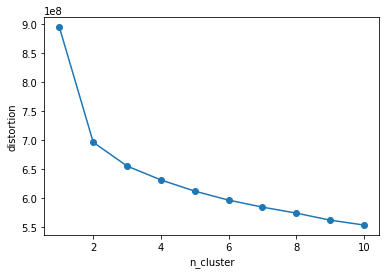

In [37]:
plt.plot(range(1,11), distorsions, marker='o')
plt.xlabel('n_cluster')
plt.ylabel('distortion')
plt.show()

from the plot above it looks like the optimal number of cluster is 2. Weird, because it should be 5 (or 6 depending on whether we include the first data-point or not).

### 2.2. Silhoutte coefficients.

Let's try have a look at the silhoutte coefficients for n_cluster = 2 and n_cluster =5.

In [38]:
km2 = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=42)

km5 = KMeans(n_clusters=5,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42)

y_km2 = km2.fit_predict(X_train)
y_km5 = km5.fit_predict(X_train)

In [39]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels2 = np.unique(y_km2)
cluster_labels5 = np.unique(y_km5)
n_clusters2 = cluster_labels2.shape[0]
n_clusters5 = cluster_labels5.shape[0]

silhouette_vals2 = silhouette_samples(X_train,
                                    y_km2,
                                     metric='euclidean')

silhouette_vals5 = silhouette_samples(X_train,
                                     y_km5,
                                     metric='euclidean')

## 3. Agglomerative Clustering

This is the bottom-up approach to hierarchical clustering